## Import of modules

In this notebook for layered graph hierarchical clustering based on tropical algebra we use the following modules of python in order to represent the object we need.

In [1]:
#Import all the necessary libraries
import pandas as pd
import numpy as np
import scipy
import matplotlib
import sklearn #importing scikit-learn library
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import networkx as nx
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist, squareform


## Light Preprocessing

Firstly we will do light pre-processing meaning we will just squeez out the missing values and we will not attempt to generate transition data for missing values (which in real life is a more favorable situation depending on the difficulty to acquire data first hand). This light pre-processing is meaning full for our studies as we want to preserve categorical data as much as possible.

In [2]:
#Load the data & summary checkup
df = pd.read_csv(r"C:\Users\pablo\OneDrive - De Vinci\STAGE_DVRC_24\CODE\clustering-mixed-data-comprising-time-series-master\clustering-mixed-data-comprising-time-series-master\data\penguins.csv")
print(df.head(), '\n')
df.isna().sum()

  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN   
4  Adelie  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  year  
0       3750.0    male  2007  
1       3800.0  female  2007  
2       3250.0  female  2007  
3          NaN     NaN  2007  
4       3450.0  female  2007   



species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
year                  0
dtype: int64

In [3]:
# Drop rows with missing values
df = df.dropna() 
df = df.reset_index(drop=True)  # Reset the index after dropping rows   
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007
...,...,...,...,...,...,...,...,...
328,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
329,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
330,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
331,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


Let's just clean the type of data we are facing : 

In [4]:
# data type modification 
df['species'] = df['species'].astype('category')
df['island'] = df['island'].astype('category')
df['bill_length_mm'] = df['bill_length_mm'].astype('float64')
df['bill_depth_mm'] = df['bill_depth_mm'].astype('float64')
df['flipper_length_mm'] = df['flipper_length_mm'].astype('float64')
df['body_mass_g'] = df['body_mass_g'].astype('float64')
df['sex'] = df['sex'].astype('category')
df['year'] = df['year'].astype('int64')

# Print data types of each column
for column in df.columns:
    print(f"Column {column}: {df[column].dtype}")

Column species: category
Column island: category
Column bill_length_mm: float64
Column bill_depth_mm: float64
Column flipper_length_mm: float64
Column body_mass_g: float64
Column sex: category
Column year: int64


In [5]:
# Encode categorical columns
categorical_columns = ['species', 'island', 'sex']
for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
print(df.head(), '\n')

   species  island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0        0       2            39.1           18.7              181.0   
1        0       2            39.5           17.4              186.0   
2        0       2            40.3           18.0              195.0   
3        0       2            36.7           19.3              193.0   
4        0       2            39.3           20.6              190.0   

   body_mass_g  sex  year  
0       3750.0    1  2007  
1       3800.0    0  2007  
2       3250.0    0  2007  
3       3450.0    0  2007  
4       3650.0    1  2007   



Let's Normalize our data in order to have smooth process later on :

In [6]:
#Normalization des données

# Select columns to normalize
columns_to_normalize = [col for col in df.columns if col not in ['species', 'island', 'sex']]

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the selected columns
scaler.fit(df[columns_to_normalize])

# Transform the selected columns using the scaler
df[columns_to_normalize] = scaler.transform(df[columns_to_normalize])

# Print the normalized dataframe
print(df)

     species  island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0          0       2       -0.896042       0.780732          -1.426752   
1          0       2       -0.822788       0.119584          -1.069474   
2          0       2       -0.676280       0.424729          -0.426373   
3          0       2       -1.335566       1.085877          -0.569284   
4          0       2       -0.859415       1.747026          -0.783651   
..       ...     ...             ...            ...                ...   
328        1       1        2.162314       1.340165           0.431094   
329        1       1       -0.090248       0.475587           0.073816   
330        1       1        1.026876       0.526444          -0.569284   
331        1       1        1.246638       0.933305           0.645461   
332        1       1        1.136757       0.780732          -0.212006   

     body_mass_g  sex      year  
0      -0.568475    1 -1.283742  
1      -0.506286    0 -1.283742  
2      -1

## Layered Numerical Graph based on euclidian distance

As the euclidian distance is only relevant for numerical data, we adapt our code to our problem and use 4 labels ; bill_length_mm	bill_depth_mm	flipper_length_mm	body_mass_g in order to compute 4 differents graph with vertices representing each line and edges representing the euclidian distance (relevant to compare such numerical data type).

In [7]:
# Function to calculate Euclidean distance between penguins based on selected features
def calculate_distance(p1, p2, features):
    distance = np.sqrt(sum((p1[feat] - p2[feat]) ** 2 for feat in features))
    return distance

# Function to create graph
def create_graph(features):
    # Create an undirected graph
    G = nx.Graph()

    # Add vertices to the graph
    for i, _ in df.iterrows():
        G.add_node(i, label=f'Line {i}')

    # Add edges with Euclidean distances as weights
    for i in range(len(df)):
        for j in range(i + 1, len(df)):
            weight = calculate_distance(df.iloc[i], df.iloc[j], features)
            G.add_edge(i, j, weight=weight)

    return G
# Features combinations for the four graphs
feature_combinations = [
    ["bill_length_mm", "bill_depth_mm"],
    ["flipper_length_mm", "flipper_length_mm"],
    ["body_mass_g", "body_mass_g"],
    ["flipper_length_mm", "flipper_length_mm"]
]
list_of_graphs = []
# Create list of our four different graphs
for features in feature_combinations:
    list_of_graphs.append(create_graph(features))

Now we will check that the list of graphs, name after the brick of layer, with each entry being a layer and as such a weighted graphs for each labels with respect to euclidian distance.

In [8]:
#Check list graph
print(list_of_graphs)

[<networkx.classes.graph.Graph object at 0x000001874E24E240>, <networkx.classes.graph.Graph object at 0x000001874E272ED0>, <networkx.classes.graph.Graph object at 0x000001870C5E9EB0>, <networkx.classes.graph.Graph object at 0x000001874E16C800>]


As graph are correctly formed we will now recombine all the edges in one big graph in order for our operation to be easier later on :

In [9]:
# Graph recombination

def combine_graphs(graphs):
    H = nx.Graph()
    for G in graphs:
        H.add_edges_from(G.edges(data=True))
    return H

# Combine the graphs into a hypergraph
H = combine_graphs(list_of_graphs)
print(H)

Graph with 333 nodes and 55278 edges


We now try to understand the repartition of the edge weights for all our numerical column in this graph and we define a thresold as the mean point of data or it's equilibrium : 

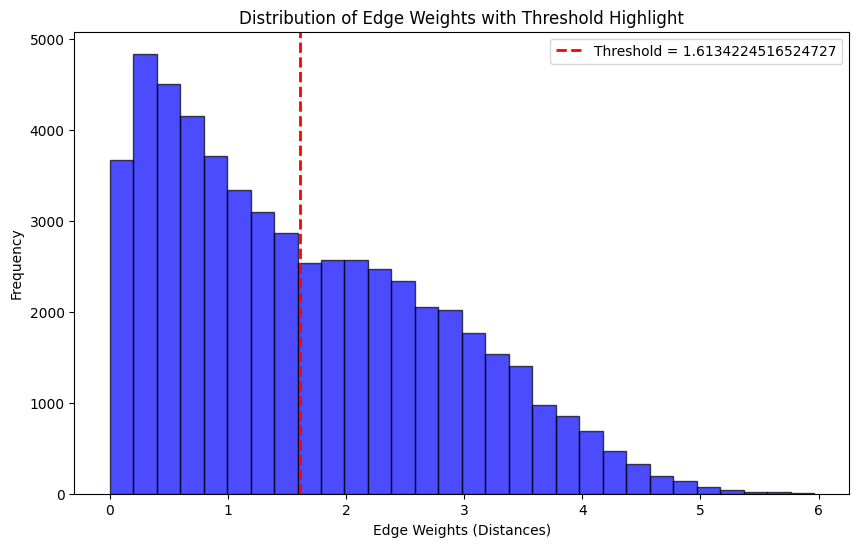

In [10]:
# Get all edge weights & graph threshold
edge_weights = [data['weight'] for _, _, data in H.edges(data=True)]

# Define a threshold for visualization
threshold = np.mean(edge_weights)  # Adjust this value as needed

# Plot the edge weights and highlight the threshold
plt.figure(figsize=(10, 6))
plt.hist(edge_weights, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label=f'Threshold = {threshold}')
plt.xlabel('Edge Weights (Distances)')
plt.ylabel('Frequency')
plt.title('Distribution of Edge Weights with Threshold Highlight')
plt.legend()
plt.show()

In [11]:
# Data assignation for node

for i, row in df.iterrows():
    H.nodes[i]['data'] = row  # Assign each row of data as node attribute
print(H.nodes[0])

{'data': species              0.000000
island               2.000000
bill_length_mm      -0.896042
bill_depth_mm        0.780732
flipper_length_mm   -1.426752
body_mass_g         -0.568475
sex                  1.000000
year                -1.283742
Name: 0, dtype: float64}


## Centrality measure computation


Computation of the two centrality measure

In [12]:
# Computation of the betweennes centrality and closeness centrality 

betweenness_centrality = nx.betweenness_centrality(H, weight='weight')

closeness_centrality = nx.closeness_centrality(H, distance='weight')

#printing results
print("Centralité d'intermédiarité :")
for node, centrality in betweenness_centrality.items():
    print(f"Nœud {node}: {centrality}")

print("\nCentralité de proximité :")
for node, centrality in closeness_centrality.items():
    print(f"Nœud {node}: {centrality}")

Centralité d'intermédiarité :
Nœud 0: 1.2604418274945968
Nœud 1: 0.8384792936442983
Nœud 2: 2424.5893913139544
Nœud 3: 382.08941004818774
Nœud 4: 40102.31406261965
Nœud 5: 0.6255772349747181
Nœud 6: 1214.4574802390678
Nœud 7: 0.07594079536736638
Nœud 8: 176.29806757212808
Nœud 9: 4.4175773514312215
Nœud 10: 6.605874104562121
Nœud 11: 608.3048836946609
Nœud 12: 22.84808811869313
Nœud 13: 1.6477218203846768
Nœud 14: 0.5895347498942706
Nœud 15: 0.0022129870593276145
Nœud 16: 0.09479662252155036
Nœud 17: 1.7716866669262938
Nœud 18: 3.301321855220675
Nœud 19: 0.042947793290436145
Nœud 20: 812.8596408008997
Nœud 21: 0.03669091092524028
Nœud 22: 408.5356814685422
Nœud 23: 0.0
Nœud 24: 0.017009812411049395
Nœud 25: 0.08313338162681559
Nœud 26: 0.037486131566428285
Nœud 27: 0.8450199393661311
Nœud 28: 0.8175180289436966
Nœud 29: 304.68526422862834
Nœud 30: 16.71946767331955
Nœud 31: 20110.88306738618
Nœud 32: 0.004222714494408642
Nœud 33: 0.3072596075099128
Nœud 34: 0.4016163721352116
Nœud 35: 

sorted betweenness
 [(4, 40102.31406261965), (31, 20110.88306738618), (40, 10085.2993000694), (42, 5057.573281253613), (46, 2536.243203815041), (2, 2424.5893913139544), (62, 1271.8446304163244), (6, 1214.4574802390678), (20, 812.8596408008997), (64, 637.7785754024159), (11, 608.3048836946609), (22, 408.5356814685422), (3, 382.08941004818774), (65, 319.81216230891266), (29, 304.68526422862834), (123, 267.45388930427197), (48, 205.31715284671608), (51, 191.18716388879497), (8, 176.29806757212808), (68, 160.36226087648714), (36, 152.6037928966754), (148, 134.14750091403764), (72, 103.17961217658699), (77, 95.65828495699859), (43, 88.27925835132054), (80, 80.40395966020147), (55, 76.42722498257453), (150, 69.30886719369876), (151, 67.27935620685722), (76, 51.84670093002205), (98, 47.85496662533131), (49, 44.1987038408809), (83, 40.30812934642691), (60, 38.27102281835885), (155, 34.71209716274069), (160, 33.7378057643997), (88, 26.04817089678321), (106, 23.933866732728017), (12, 22.84808811

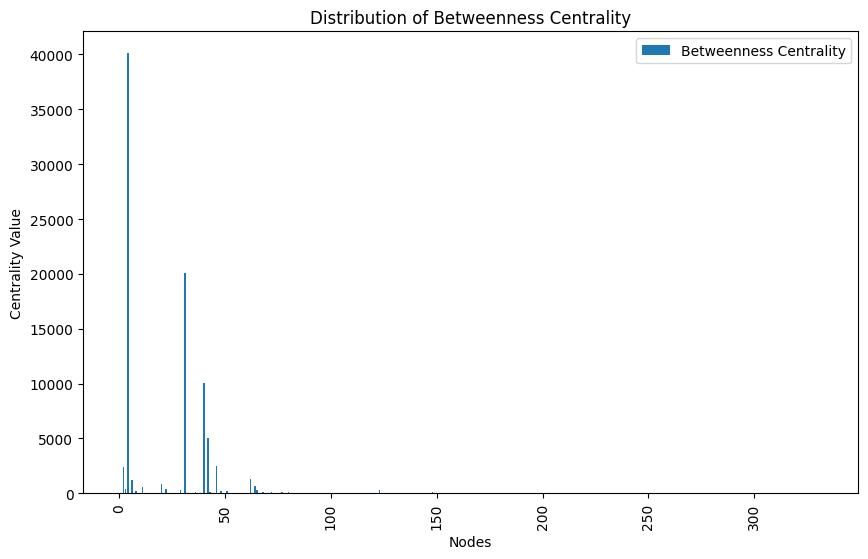

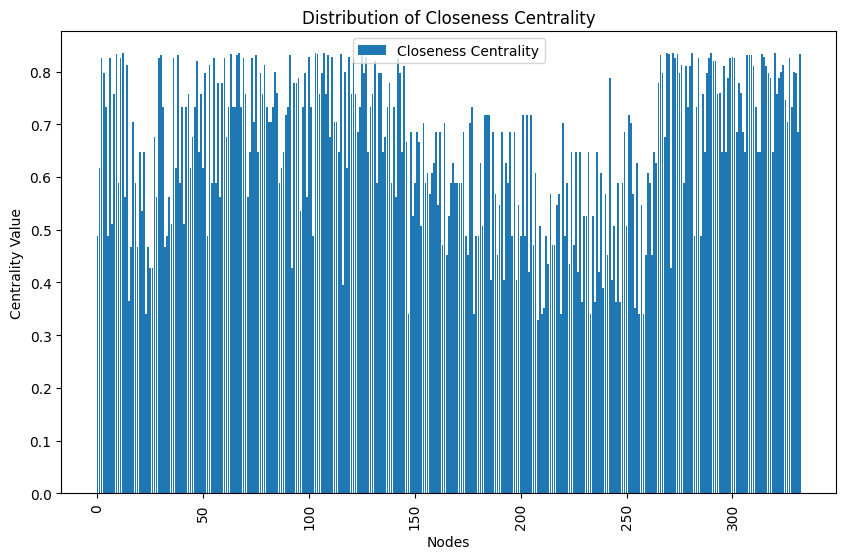

In [13]:
# Sorting values of  betweenness & closeness centrality
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
sorted_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)
print("sorted betweenness\n", sorted_betweenness)
print("sorted closeness\n",sorted_closeness)

# Node extraction
nodes_betweenness, values_betweenness = zip(*sorted_betweenness)
nodes_closeness, values_closeness = zip(*sorted_closeness)

# print nodes and values
plt.figure(figsize=(10, 6))
plt.bar(nodes_betweenness, values_betweenness, label='Betweenness Centrality')
plt.xlabel('Nodes')
plt.ylabel('Centrality Value')
plt.title('Distribution of Betweenness Centrality')
plt.xticks(rotation=90)  # Rotate node labels to avoid overlap
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(nodes_closeness, values_closeness, label='Closeness Centrality')
plt.xlabel('Nodes')
plt.ylabel('Centrality Value')
plt.title('Distribution of Closeness Centrality')
plt.xticks(rotation=90)  # Rotate node labels to avoid overlap
plt.legend()
plt.show()

In [14]:
# Calculate the number of nodes to select (top 20%)
num_nodes_betweenness = int(len(betweenness_centrality) * 0.2)
num_nodes_closeness = int(len(closeness_centrality) * 0.2)

# Select top 20% of nodes
top_betweenness_nodes = sorted_betweenness[:num_nodes_betweenness]
top_closeness_nodes = sorted_closeness[:num_nodes_closeness]

# Display the selected nodes
print("Top 20% Nodes based on Betweenness Centrality:")
for node, value in top_betweenness_nodes:
    print(f"Node: {node}, Betweenness Centrality: {value}")

print("\nTop 20% Nodes based on Closeness Centrality:")
for node, value in top_closeness_nodes:
    print(f"Node: {node}, Closeness Centrality: {value}")


Top 20% Nodes based on Betweenness Centrality:
Node: 4, Betweenness Centrality: 40102.31406261965
Node: 31, Betweenness Centrality: 20110.88306738618
Node: 40, Betweenness Centrality: 10085.2993000694
Node: 42, Betweenness Centrality: 5057.573281253613
Node: 46, Betweenness Centrality: 2536.243203815041
Node: 2, Betweenness Centrality: 2424.5893913139544
Node: 62, Betweenness Centrality: 1271.8446304163244
Node: 6, Betweenness Centrality: 1214.4574802390678
Node: 20, Betweenness Centrality: 812.8596408008997
Node: 64, Betweenness Centrality: 637.7785754024159
Node: 11, Betweenness Centrality: 608.3048836946609
Node: 22, Betweenness Centrality: 408.5356814685422
Node: 3, Betweenness Centrality: 382.08941004818774
Node: 65, Betweenness Centrality: 319.81216230891266
Node: 29, Betweenness Centrality: 304.68526422862834
Node: 123, Betweenness Centrality: 267.45388930427197
Node: 48, Betweenness Centrality: 205.31715284671608
Node: 51, Betweenness Centrality: 191.18716388879497
Node: 8, Bet

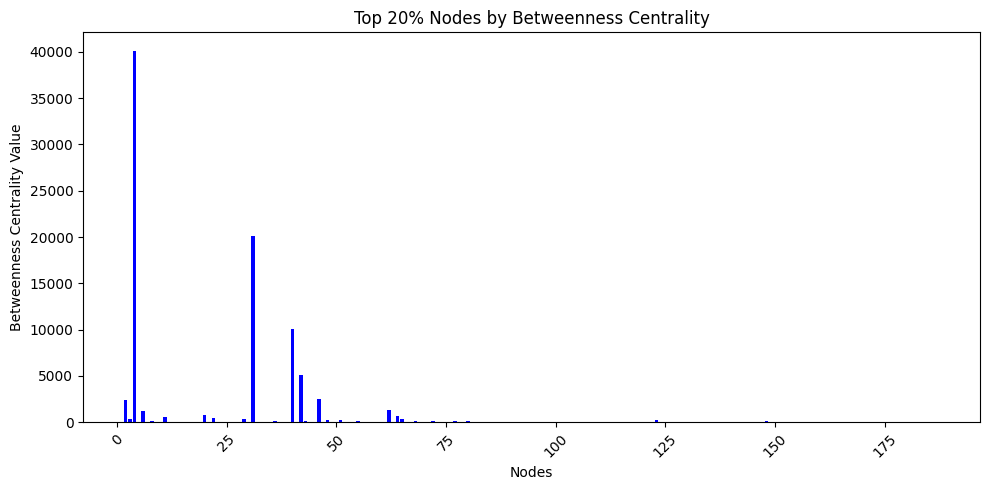

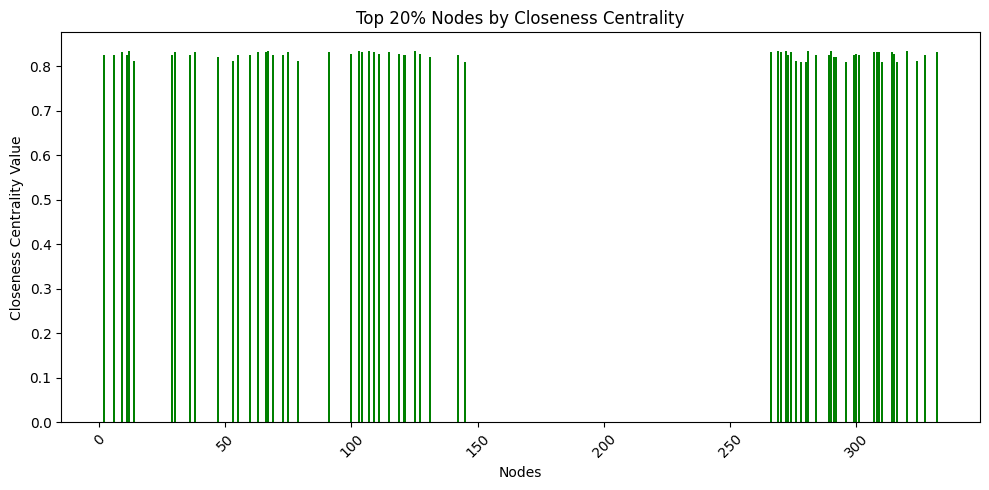

In [15]:
# Betweenness Centrality & Closeness centrality node selection visualization
nodes_betweenness, values_betweenness = zip(*top_betweenness_nodes)
plt.figure(figsize=(10, 5))
plt.bar(nodes_betweenness, values_betweenness, color='blue')
plt.xlabel('Nodes')
plt.ylabel('Betweenness Centrality Value')
plt.title('Top 20% Nodes by Betweenness Centrality')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


nodes_closeness, values_closeness = zip(*top_closeness_nodes)
plt.figure(figsize=(10, 5))
plt.bar(nodes_closeness, values_closeness, color='green')
plt.xlabel('Nodes')
plt.ylabel('Closeness Centrality Value')
plt.title('Top 20% Nodes by Closeness Centrality')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Clustering initialization and searching

The following hierarchical clustering procedure are to be executed wisely depending on which you want to proceed your analysis later on :

In [16]:
#Version CLOSENESS --------------------------------------
node_numbers_closeness = [node for node, closeness in top_closeness_nodes]

def rows_similar(row1, row2):
    # Fonction pour vérifier la similarité entre deux lignes de données catégoriques
    cat_1_values = row1['species'] == row2['species']
    cat_2_values = row1['island'] == row2['island']
    cat_3_values = row1['sex'] == row2['sex']
    return sum([cat_1_values, cat_2_values, cat_3_values]) >= 2

def percolation_clustering(H, threshold):
    clusters = []
    visited_nodes = set()
    
    def can_add_to_cluster(cluster, new_node):
        if not cluster:
            return True
        
        for node in cluster:
            if H.has_edge(new_node, node):
                if H[new_node][node]['weight'] < threshold or not rows_similar(H.nodes[new_node]['data'], H.nodes[node]['data']):
                    return False
        return True
    
    for start_node in node_numbers_closeness:
        
        if start_node not in visited_nodes:
            
            cluster = []
            stack = [start_node]
            
            while stack:
                current_node = stack.pop()
                #print("cnode", current_node)
                if current_node not in visited_nodes:
                    visited_nodes.add(current_node)
                    #print("vnode", visited_nodes)
                    cluster.append(current_node)
                    #print("cluster_constr", cluster)
                    
                    
                    for neighbor in H.neighbors(current_node):
                        if neighbor not in visited_nodes and can_add_to_cluster(cluster, neighbor):
                            stack.append(neighbor)
                
            print("cluster", cluster)
                            
            if cluster:
                clusters.append(cluster)
    
    return clusters

clusters = percolation_clustering(H, threshold)
print(clusters)

total_elements = sum(len(cluster) for cluster in clusters)
print("Nombre d'element totalisé", total_elements)

cluster [12, 116, 26, 24, 19, 16, 5, 0]
cluster [67]
cluster [103, 264, 258, 256, 254, 233, 219, 211, 210, 208, 178, 147, 262, 259, 250, 248, 247, 245, 243, 240, 239, 237, 235, 231, 229, 227, 225, 223, 221, 216, 215, 213, 206, 204, 202, 200, 198, 196, 194, 192, 189, 188, 186, 182, 180, 175, 174, 172, 171, 169, 166, 165, 163, 161, 159, 157, 155, 153, 150, 149, 102, 52, 23, 15]
cluster [107]
cluster [125]
cluster [269, 285, 282, 271]
cluster [272]
cluster [281]
cluster [290]
cluster [320]
cluster [9, 41, 7]
cluster [63]
cluster [104, 261, 260, 257, 253, 246, 244, 241, 238, 234, 230, 222, 218, 217, 214, 212, 209, 207, 199, 190, 179, 170, 167, 158, 156, 92, 35, 33, 32, 25]
cluster [115]
cluster [270]
cluster [274]
cluster [314]
cluster [332]
cluster [30, 312]
cluster [38]
cluster [66]
cluster [75]
cluster [91]
cluster [109]
cluster [266]
cluster [307]
cluster [308]
cluster [309]
cluster [100, 96, 21]
cluster [111]
cluster [119]
cluster [127]
cluster [300]
cluster [315]
cluster [2]
cluster 

In [17]:
#Version BETWEENES --------------------------------------
node_numbers_betweenness = [node for node, closeness in top_betweenness_nodes]

def rows_similar(row1, row2):
    # Fonction pour vérifier la similarité entre deux lignes de données catégoriques
    cat_1_values = row1['species'] == row2['species']
    cat_2_values = row1['island'] == row2['island']
    cat_3_values = row1['sex'] == row2['sex']
    return sum([cat_1_values, cat_2_values, cat_3_values]) >= 2

def percolation_clustering(H, threshold):
    clusters = []
    visited_nodes = set()
    
    def can_add_to_cluster(cluster, new_node):
        if not cluster:
            return True
        
        for node in cluster:
            if H.has_edge(new_node, node):
                if H[new_node][node]['weight'] < threshold or not rows_similar(H.nodes[new_node]['data'], H.nodes[node]['data']):
                    return False
        return True
    
    for start_node in node_numbers_betweenness:
        
        if start_node not in visited_nodes:
            
            cluster = []
            stack = [start_node]
            
            while stack:
                current_node = stack.pop()
                #print("cnode", current_node)
                if current_node not in visited_nodes:
                    visited_nodes.add(current_node)
                    #print("vnode", visited_nodes)
                    cluster.append(current_node)
                    #print("cluster_constr", cluster)
                    
                    
                    for neighbor in H.neighbors(current_node):
                        if neighbor not in visited_nodes and can_add_to_cluster(cluster, neighbor):
                            stack.append(neighbor)
                
            print("cluster", cluster)
                            
            if cluster:
                clusters.append(cluster)
    
    return clusters

clusters = percolation_clustering(H, threshold)
print(clusters)

total_elements = sum(len(cluster) for cluster in clusters)
print("Nombre d'element totalisé", total_elements)

cluster [4, 123, 89]
cluster [31, 331, 328, 325, 312, 305, 302]
cluster [40]
cluster [42, 23, 15]
cluster [46, 263, 261, 260, 257, 255, 253, 251, 249, 246, 244, 241, 238, 236, 234, 232, 230, 228, 226, 224, 222, 220, 218, 217, 214, 212, 209, 207, 205, 203, 201, 199, 197, 195, 193, 191, 190, 187, 185, 183, 181, 179, 177, 176, 173, 170, 168, 167, 164, 162, 160, 158, 156, 154, 152, 151, 148, 146]
cluster [2, 116, 92, 25]
cluster [62]
cluster [6, 26]
cluster [20, 242, 95]
cluster [64]
cluster [11]
cluster [22]
cluster [3]
cluster [65]
cluster [29, 271]
cluster [48]
cluster [51, 264, 258, 256, 254, 233, 219, 211, 210, 208, 178, 147, 262, 259, 252, 250, 248, 247, 245, 243, 240, 239, 237, 235, 231, 229, 227, 225, 223, 221, 216, 215, 213, 206, 204, 202, 200, 198, 196, 194, 192, 189, 188, 186, 182, 180, 175, 174, 172, 171, 169, 166, 165, 163, 161, 159, 157, 155, 153, 150, 149]
cluster [8]
cluster [68]
cluster [36]
cluster [72]
cluster [77]
cluster [43]
cluster [80]
cluster [55]
cluster [76]
clus

In [44]:
# Version CLOSENESS MERGED --------------------------------------
node_numbers_closeness = [node for node, closeness in top_closeness_nodes]

def rows_similar(row1, row2):
    # Function to check the similarity between two rows of categorical data
    cat_1_values = row1['species'] == row2['species']
    cat_2_values = row1['island'] == row2['island']
    cat_3_values = row1['sex'] == row2['sex']
    return sum([cat_1_values, cat_2_values, cat_3_values]) >= 2

def can_add_to_cluster(cluster, new_node, H, threshold):
    if not cluster:
        return True
    
    for node in cluster:
        if H.has_edge(new_node, node):
            if H[new_node][node]['weight'] < threshold or not rows_similar(H.nodes[new_node]['data'], H.nodes[node]['data']):
                return False
    return True

def percolation_clustering(H, threshold):
    clusters = []
    
    for start_node in node_numbers_closeness:
        cluster = []
        stack = [start_node]
        
        while stack:
            current_node = stack.pop()
            if current_node not in cluster:  # Node can participate in multiple clusters
                cluster.append(current_node)
                
                for neighbor in H.neighbors(current_node):
                    if can_add_to_cluster(cluster, neighbor, H, threshold):
                        stack.append(neighbor)
        
        print("Initial cluster formed", cluster)
        
        if cluster:
            clusters.append(cluster)
    
    return clusters

def merge_clusters(clusters, H, threshold, overlap_threshold):
    """
    Merge clusters based on node overlap and similarity.

    Parameters:
    clusters (list of lists): List of clusters where each cluster is a list of nodes.
    H (networkx.Graph): A NetworkX graph where edges have a 'weight' attribute representing similarity.
    threshold (float): The similarity threshold for merging clusters.
    overlap_threshold (float): The minimum overlap required for merging two clusters.

    Returns:
    list of lists: The new list of merged clusters.
    """
    merged_clusters = []
    used_clusters = set()
    
    def calculate_overlap(cluster1, cluster2):
        return len(set(cluster1).intersection(set(cluster2)))

    def can_merge_clusters(cluster1, cluster2, H, threshold, overlap_threshold):
        """
        Determine if two clusters can be merged based on node overlap and similarity.
        """
        overlap = calculate_overlap(cluster1, cluster2)
        if overlap / min(len(cluster1), len(cluster2)) < overlap_threshold:
            return False
        
        # Compute the average similarity between nodes in the overlap
        similarities = []
        for node1 in cluster1:
            for node2 in cluster2:
                if H.has_edge(node1, node2):
                    similarities.append(H[node1][node2].get('weight', 0))
        
        if len(similarities) == 0:
            return False
        
        average_similarity = np.mean(similarities)
        return average_similarity >= threshold

    for i in range(len(clusters)):
        if i in used_clusters:
            continue
        
        merged_cluster = set(clusters[i])
        
        for j in range(i + 1, len(clusters)):
            if j in used_clusters:
                continue
            
            if can_merge_clusters(merged_cluster, clusters[j], H, threshold, overlap_threshold):
                merged_cluster.update(clusters[j])
                used_clusters.add(j)
        
        merged_clusters.append(list(merged_cluster))
        used_clusters.add(i)
    
    return merged_clusters

clusters = percolation_clustering(H, threshold)
print("Initial clusters:", clusters)

# Experiment with different overlap thresholds
overlap_threshold = 1
print(f"Testing overlap threshold: {overlap_threshold}")
merged_clusters = merge_clusters(clusters, H, threshold, overlap_threshold)
print("Merged clusters:", merged_clusters)
total_elements = sum(len(cluster) for cluster in merged_clusters)
print("Total elements after merging", total_elements)

total_elements = sum(len(cluster) for cluster in merged_clusters)
print("Total elements after merging", total_elements)

Initial cluster formed [12, 116, 26, 24, 19, 16, 5, 0]
Initial cluster formed [67, 116, 26, 24, 19, 16, 5, 0]
Initial cluster formed [103, 264, 258, 24, 19, 16, 256, 254, 233, 219, 211, 210, 208, 178, 147, 262, 259, 250, 248, 247, 245, 243, 240, 239, 237, 235, 231, 229, 227, 225, 223, 221, 216, 215, 213, 206, 204, 202, 200, 198, 196, 194, 192, 189, 188, 186, 182, 180, 175, 174, 172, 171, 169, 166, 165, 163, 161, 159, 157, 155, 153, 150, 149, 102, 52, 26, 23, 15, 0]
Initial cluster formed [107, 264, 258, 24, 19, 16, 256, 254, 233, 219, 211, 210, 208, 178, 147, 262, 259, 250, 248, 247, 245, 243, 240, 239, 237, 235, 231, 229, 227, 225, 223, 221, 216, 215, 213, 206, 204, 202, 200, 198, 196, 194, 192, 189, 188, 186, 182, 180, 175, 174, 172, 171, 169, 166, 165, 163, 161, 159, 157, 155, 153, 150, 149, 102, 52, 26, 23, 15, 0]
Initial cluster formed [125, 116, 26, 24, 19, 16, 5, 0]
Initial cluster formed [269, 285, 282, 271, 26]
Initial cluster formed [272, 285, 282, 271, 26]
Initial cluster fo

In [19]:
# Version BETWEENNESS MERGED --------------------------------------
node_numbers_betweenness = [node for node, betweenness in top_betweenness_nodes]

def rows_similar(row1, row2):
    # Function to check the similarity between two rows of categorical data
    cat_1_values = row1['species'] == row2['species']
    cat_2_values = row1['island'] == row2['island']
    cat_3_values = row1['sex'] == row2['sex']
    return sum([cat_1_values, cat_2_values, cat_3_values]) >= 2

def can_add_to_cluster(cluster, new_node, H, threshold):
    if not cluster:
        return True
    
    for node in cluster:
        if H.has_edge(new_node, node):
            if H[new_node][node]['weight'] < threshold or not rows_similar(H.nodes[new_node]['data'], H.nodes[node]['data']):
                return False
    return True

def percolation_clustering(H, threshold):
    clusters = []
    
    for start_node in node_numbers_betweenness:
        cluster = []
        stack = [start_node]
        
        while stack:
            current_node = stack.pop()
            if current_node not in cluster:  # Node can participate in multiple clusters
                cluster.append(current_node)
                
                for neighbor in H.neighbors(current_node):
                    if can_add_to_cluster(cluster, neighbor, H, threshold):
                        stack.append(neighbor)
        
        print("Initial cluster formed", cluster)
        
        if cluster:
            clusters.append(cluster)
    
    return clusters

def merge_clusters(clusters, H, threshold):
    merged_clusters = []
    used_clusters = set()
    
    for i in range(len(clusters)):
        if i in used_clusters:
            continue
        
        merged_cluster = set(clusters[i])
        
        for j in range(i + 1, len(clusters)):
            if j in used_clusters:
                continue
            
            intersection = merged_cluster.intersection(clusters[j])
            if intersection:
                # Check if clusters can be merged based on intersection and similarity
                merged = True
                for node in intersection:
                    if not can_add_to_cluster(merged_cluster, node, H, threshold):
                        merged = False
                        break
                
                if merged:
                    merged_cluster.update(clusters[j])
                    used_clusters.add(j)
        
        merged_clusters.append(list(merged_cluster))
        used_clusters.add(i)
    
    return merged_clusters

clusters = percolation_clustering(H, threshold)
print("Initial clusters:", clusters)

# Apply cluster merging based on coverage
merged_clusters = merge_clusters(clusters, H, threshold)
print("Merged clusters:", merged_clusters)

total_elements = sum(len(cluster) for cluster in merged_clusters)
print("Total elements after merging", total_elements)


Initial cluster formed [4, 123, 89]
Initial cluster formed [31, 331, 328, 325, 312, 305, 302, 123, 89]
Initial cluster formed [40, 331, 328, 325, 312, 305, 302, 123, 89]
Initial cluster formed [42, 89, 23, 15]
Initial cluster formed [46, 263, 23, 15, 261, 260, 257, 255, 253, 251, 249, 246, 244, 241, 238, 236, 234, 232, 230, 228, 226, 224, 222, 220, 218, 217, 214, 212, 209, 207, 205, 203, 201, 199, 197, 195, 193, 191, 190, 187, 185, 183, 181, 179, 177, 176, 173, 170, 168, 167, 164, 162, 160, 158, 156, 154, 152, 151, 148, 146]
Initial cluster formed [2, 116, 92, 25, 23, 15]
Initial cluster formed [62, 123, 23, 15]
Initial cluster formed [6, 116, 26]
Initial cluster formed [20, 263, 261, 260, 257, 255, 253, 251, 249, 246, 244, 242, 241, 238, 236, 234, 232, 230, 228, 226, 224, 222, 220, 218, 217, 214, 212, 209, 207, 205, 203, 201, 199, 197, 195, 193, 191, 190, 187, 185, 183, 181, 179, 177, 176, 173, 170, 168, 167, 164, 162, 160, 158, 156, 154, 152, 151, 148, 146, 95]
Initial cluster formed

## Dendogramme visualization and metrics

For Merged_Clusters : 

     species    island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0   0.000000  1.125000       -0.847969       0.621802          -1.382092   
1   0.000000  1.125000       -0.772426       0.507373          -1.382092   
2   1.710145  0.043478        0.722978      -0.554831           1.071088   
3   1.710145  0.043478        0.720324      -0.551146           1.071088   
4   0.000000  1.125000       -0.834234       0.526444          -1.382092   
..       ...       ...             ...            ...                ...   
61  0.500000  1.000000        0.065417       0.551873          -1.219530   
62  0.500000  1.000000        0.037947       0.628159          -1.219530   
63  0.500000  1.000000        0.105707       0.689189          -1.219530   
64  0.500000  1.000000        0.043441       0.572216          -1.219530   
65  0.500000  1.000000        0.054429       0.597645          -1.219530   

    body_mass_g       sex      year  
0     -0.479079  0.750000 -0.975755  
1     -0.53

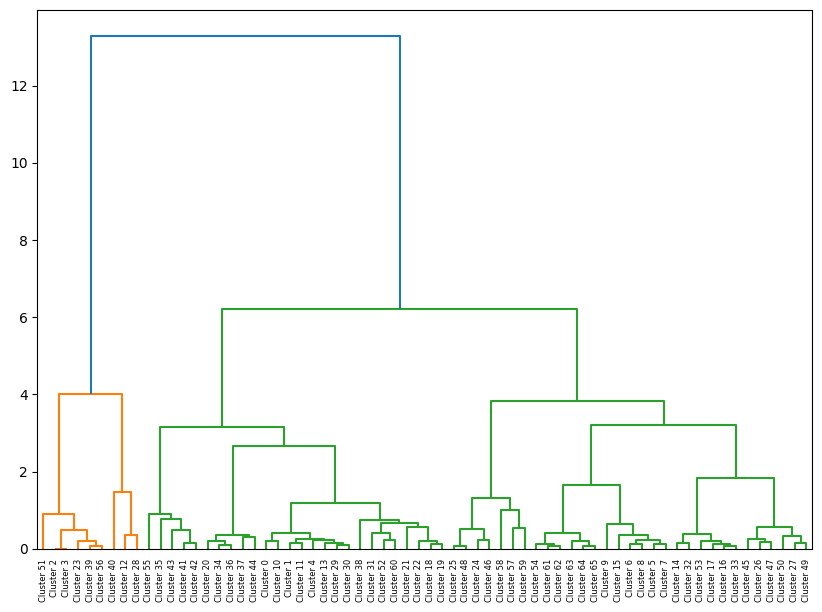

In [45]:
#Data recombination for merged clusters --------------------------------------

def clusters_to_data(clusters, data):
    cluster_data = []
    for cluster in clusters:
        cluster_df = data.iloc[cluster]
        cluster_means = cluster_df.mean(numeric_only=True).values
        cluster_data.append(cluster_means)
    return pd.DataFrame(cluster_data, columns=data.select_dtypes(include=[np.number]).columns)

def dunn_index(data, labels):
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)

    # Compute pairwise distances
    distances = squareform(pdist(data))

    # Compute intra-cluster distances
    intra_cluster_distances = np.zeros(n_clusters)
    for label in unique_labels:
        cluster_points = data[labels == label]
        if len(cluster_points) > 1:
            cluster_distances = pdist(cluster_points)
            intra_cluster_distances[label] = np.max(cluster_distances)
        else:
            intra_cluster_distances[label] = 0

    # Compute inter-cluster distances
    inter_cluster_distances = np.full((n_clusters, n_clusters), np.inf)
    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            cluster_i_points = data[labels == unique_labels[i]]
            cluster_j_points = data[labels == unique_labels[j]]
            if len(cluster_i_points) > 0 and len(cluster_j_points) > 0:
                inter_cluster_distances[i, j] = np.min(pdist(np.vstack([cluster_i_points, cluster_j_points])))

    # Compute Dunn Index
    min_inter_cluster_distance = np.min(inter_cluster_distances[inter_cluster_distances < np.inf])
    max_intra_cluster_distance = np.max(intra_cluster_distances)

    if max_intra_cluster_distance == 0:
        return 0
    return min_inter_cluster_distance / max_intra_cluster_distance

cluster_data = clusters_to_data(merged_clusters, df)
print(cluster_data)
# Apply hierarchical clustering
Z = linkage(cluster_data, method='ward')

# Generate labels for each point based on clusters
labels = np.concatenate([[i] * len(cluster) for i, cluster in enumerate(merged_clusters)])

# Flattened cluster data
flattened_cluster_data = df.iloc[np.concatenate(merged_clusters)]

# Silhouette Coefficient
silhouette_avg = silhouette_score(flattened_cluster_data, labels)
print(f"Silhouette Coefficient: {silhouette_avg:.3f}")

# Dunn Index
dunn_idx = dunn_index(flattened_cluster_data, np.array(labels))
print(f"Dunn Index: {dunn_idx:.3f}")

# Davies-Bouldin Index
davies_bouldin_idx = davies_bouldin_score(flattened_cluster_data, labels)
print(f"Davies-Bouldin Index: {davies_bouldin_idx:.3f}")

# Cophenetic Correlation Coefficient (CCC)
cophenet_corr, _ = cophenet(Z, pdist(cluster_data))
print(f"Cophenetic Correlation Coefficient (CCC): {cophenet_corr:.3f}")

# Plot dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=[f'Cluster {i}' for i in range(len(cluster_data))])
plt.show()

For Non-Merged_Clusters : 

     species    island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0   0.000000  1.125000       -0.847969       0.621802          -1.382092   
1   0.000000  1.125000       -0.772426       0.507373          -1.382092   
2   1.710145  0.043478        0.722978      -0.554831           1.071088   
3   1.710145  0.043478        0.720324      -0.551146           1.071088   
4   0.000000  1.125000       -0.834234       0.526444          -1.382092   
..       ...       ...             ...            ...                ...   
61  0.500000  1.000000        0.065417       0.551873          -1.219530   
62  0.500000  1.000000        0.037947       0.628159          -1.219530   
63  0.500000  1.000000        0.105707       0.689189          -1.219530   
64  0.500000  1.000000        0.043441       0.572216          -1.219530   
65  0.500000  1.000000        0.054429       0.597645          -1.219530   

    body_mass_g       sex      year  
0     -0.479079  0.750000 -0.975755  
1     -0.53

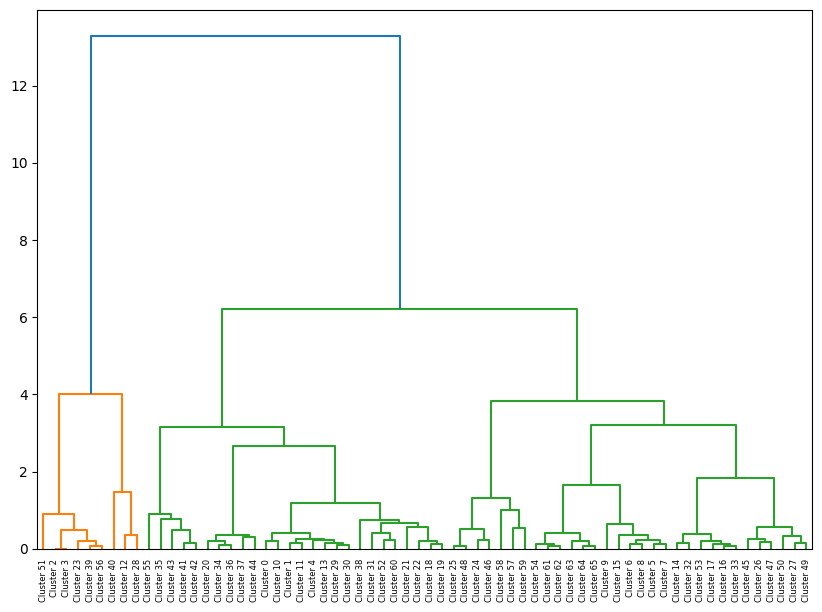

In [32]:
#Data recombination for non-merged clusters--------------------------------------
def clusters_to_data(clusters, data):
    cluster_data = []
    for cluster in clusters:
        cluster_df = data.iloc[cluster]
        cluster_means = cluster_df.mean(numeric_only=True).values
        cluster_data.append(cluster_means)
    return pd.DataFrame(cluster_data, columns=data.select_dtypes(include=[np.number]).columns)

def dunn_index(data, labels):
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)

    # Compute pairwise distances
    distances = squareform(pdist(data))

    # Compute intra-cluster distances
    intra_cluster_distances = np.zeros(n_clusters)
    for label in unique_labels:
        cluster_points = data[labels == label]
        if len(cluster_points) > 1:
            cluster_distances = pdist(cluster_points)
            intra_cluster_distances[label] = np.max(cluster_distances)
        else:
            intra_cluster_distances[label] = 0

    # Compute inter-cluster distances
    inter_cluster_distances = np.full((n_clusters, n_clusters), np.inf)
    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            cluster_i_points = data[labels == unique_labels[i]]
            cluster_j_points = data[labels == unique_labels[j]]
            if len(cluster_i_points) > 0 and len(cluster_j_points) > 0:
                inter_cluster_distances[i, j] = np.min(pdist(np.vstack([cluster_i_points, cluster_j_points])))

    # Compute Dunn Index
    min_inter_cluster_distance = np.min(inter_cluster_distances[inter_cluster_distances < np.inf])
    max_intra_cluster_distance = np.max(intra_cluster_distances)

    if max_intra_cluster_distance == 0:
        return 0
    return min_inter_cluster_distance / max_intra_cluster_distance



cluster_data = clusters_to_data(clusters, df)
print(cluster_data)
# Apply hierarchical clustering
Z = linkage(cluster_data, method='ward')

# Flatten clusters and create labels for each point
labels = []
for i, cluster in enumerate(clusters):
    labels.extend([i] * len(cluster))

flattened_cluster_data = df.iloc[np.concatenate(clusters)]

# Silhouette Coefficient
silhouette_avg = silhouette_score(flattened_cluster_data, labels)
print(f"Silhouette Coefficient: {silhouette_avg:.3f}")

# Dunn Index
dunn_idx = dunn_index(flattened_cluster_data, np.array(labels))
print(f"Dunn Index: {dunn_idx:.3f}")

# Davies-Bouldin Index
davies_bouldin_idx = davies_bouldin_score(flattened_cluster_data, labels)
print(f"Davies-Bouldin Index: {davies_bouldin_idx:.3f}")

# Cophenetic Correlation Coefficient (CCC)
cophenet_corr, _ = cophenet(Z, pdist(cluster_data))
print(f"Cophenetic Correlation Coefficient (CCC): {cophenet_corr:.3f}")

# Plot dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=[f'Cluster {i}' for i in range(len(cluster_data))])
plt.show()

## Graph and some data visualization

Visualization of the hyper Graph :

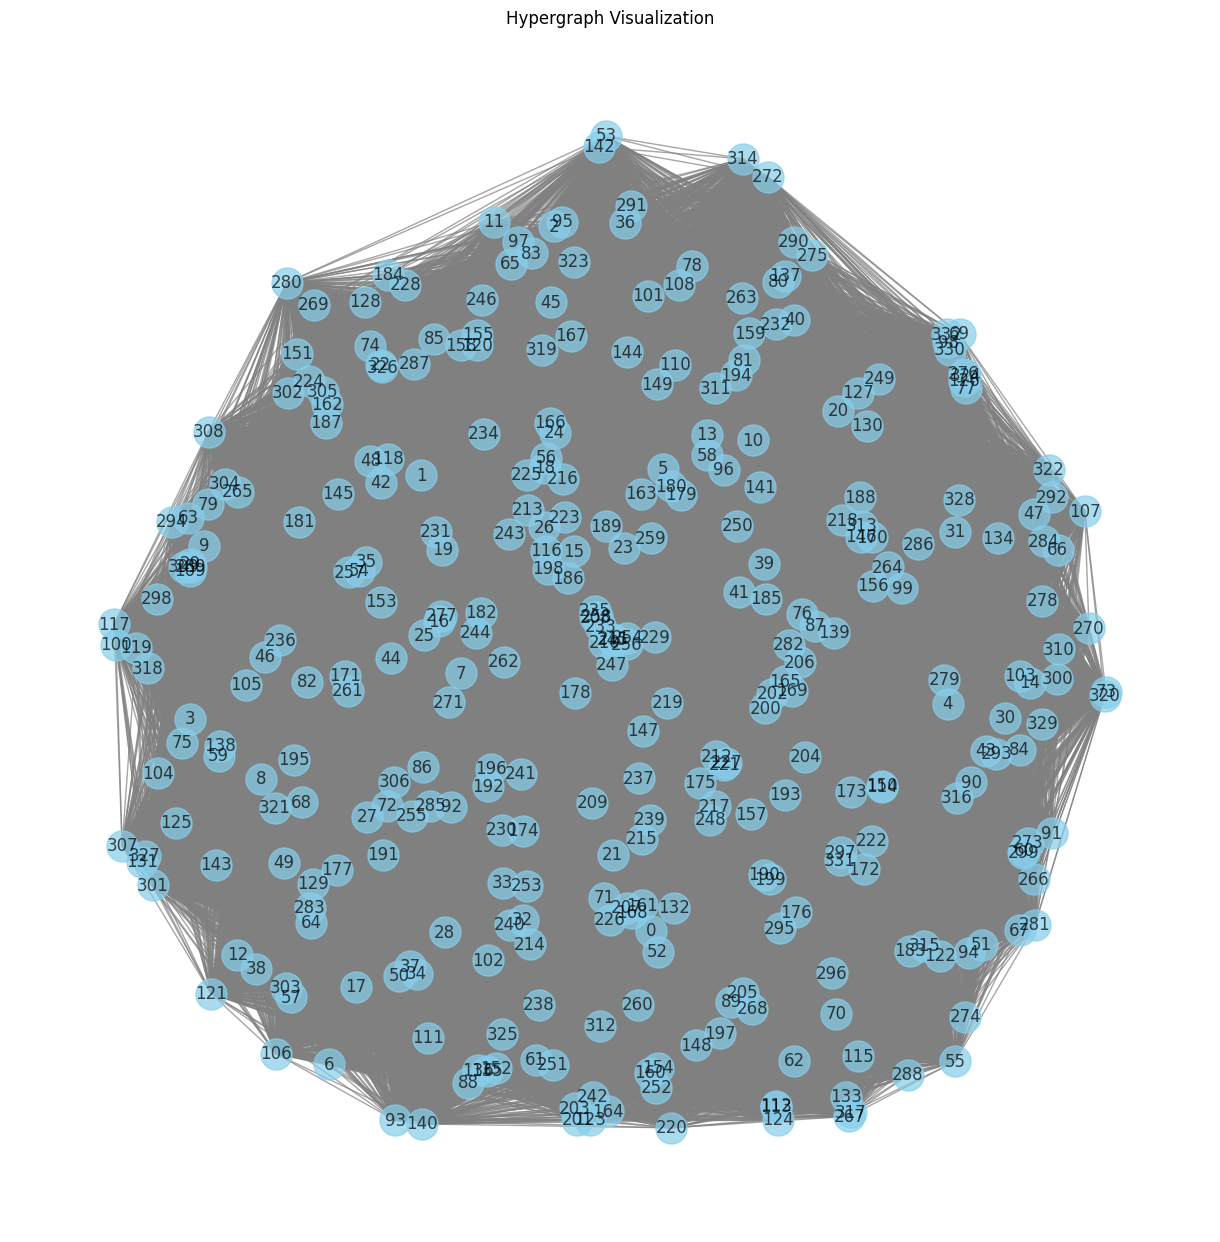

In [ ]:
# Visualization of the hypergraph
pos = nx.spring_layout(H)  # Position nodes using Fruchterman-Reingold force-directed algorithm
plt.figure(figsize=(12, 12))
nx.draw(H, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500, alpha=0.7)
plt.title('Hypergraph Visualization')
plt.show()

Correlation Matrix of the data

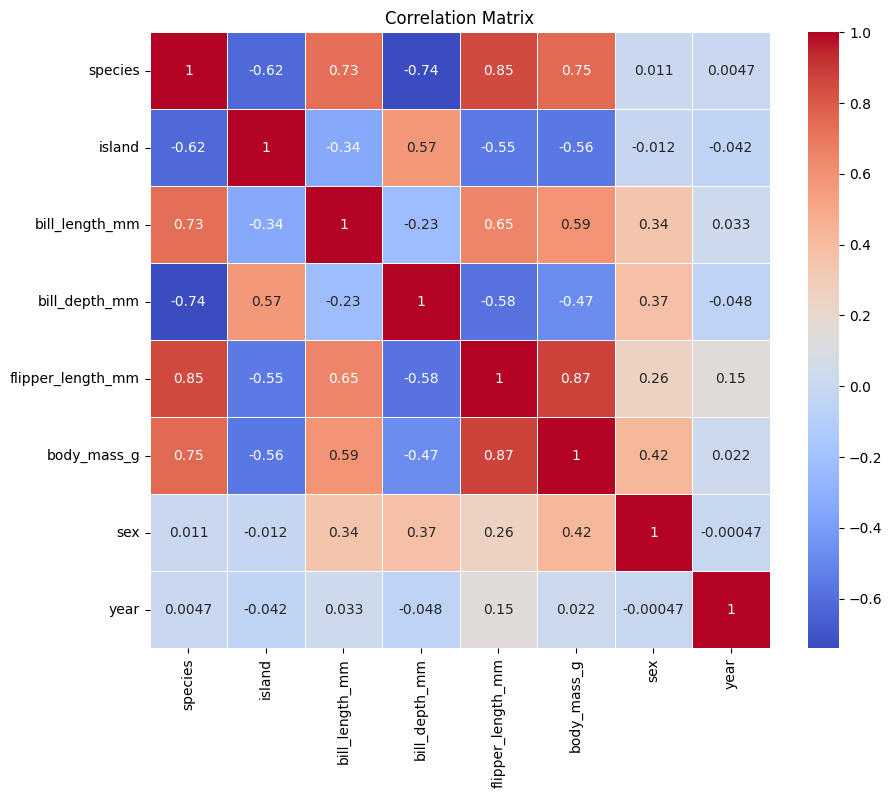

In [ ]:
# Visualization of the correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Versions

In [ ]:
#Packages version----------------------------------------

def print_package_versions():
    print(f"pandas (version {pd.__version__}) : To handle mixed datasets and data manipulation.")
    print(f"scipy (version {scipy.__version__}) : For hierarchical clustering and other scientific computations.")
    print(f"numpy (version {np.__version__}) : For numerical operations and array management.")
    print(f"networkx (version {nx.__version__}) : For graph manipulation and visualization.")
    print(f"matplotlib (version {matplotlib.__version__}) : For short visualization.")
    print(f"seaborn (version {sns.__version__}) : For enhanced visualization.")
    print(f"scikit-learn (version {sklearn.__version__}) : For machine learning algorithms and preprocessing.")

# Execute the function to print versions
print_package_versions()



pandas (version 2.2.1) : To handle mixed datasets and data manipulation.
scipy (version 1.13.0) : For hierarchical clustering and other scientific computations.
numpy (version 1.26.4) : For numerical operations and array management.
networkx (version 3.3) : For graph manipulation and visualization.
matplotlib (version 3.8.3) : For short visualization.
seaborn (version 0.13.2) : For enhanced visualization.
scikit-learn (version 1.4.2) : For machine learning algorithms and preprocessing.
